In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from catboost import CatBoostClassifier

import shap

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots 

import warnings
warnings.filterwarnings('ignore')

# The Data

In [2]:
data = pd.read_csv('/home/shaggy/data.csv')
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


[None]

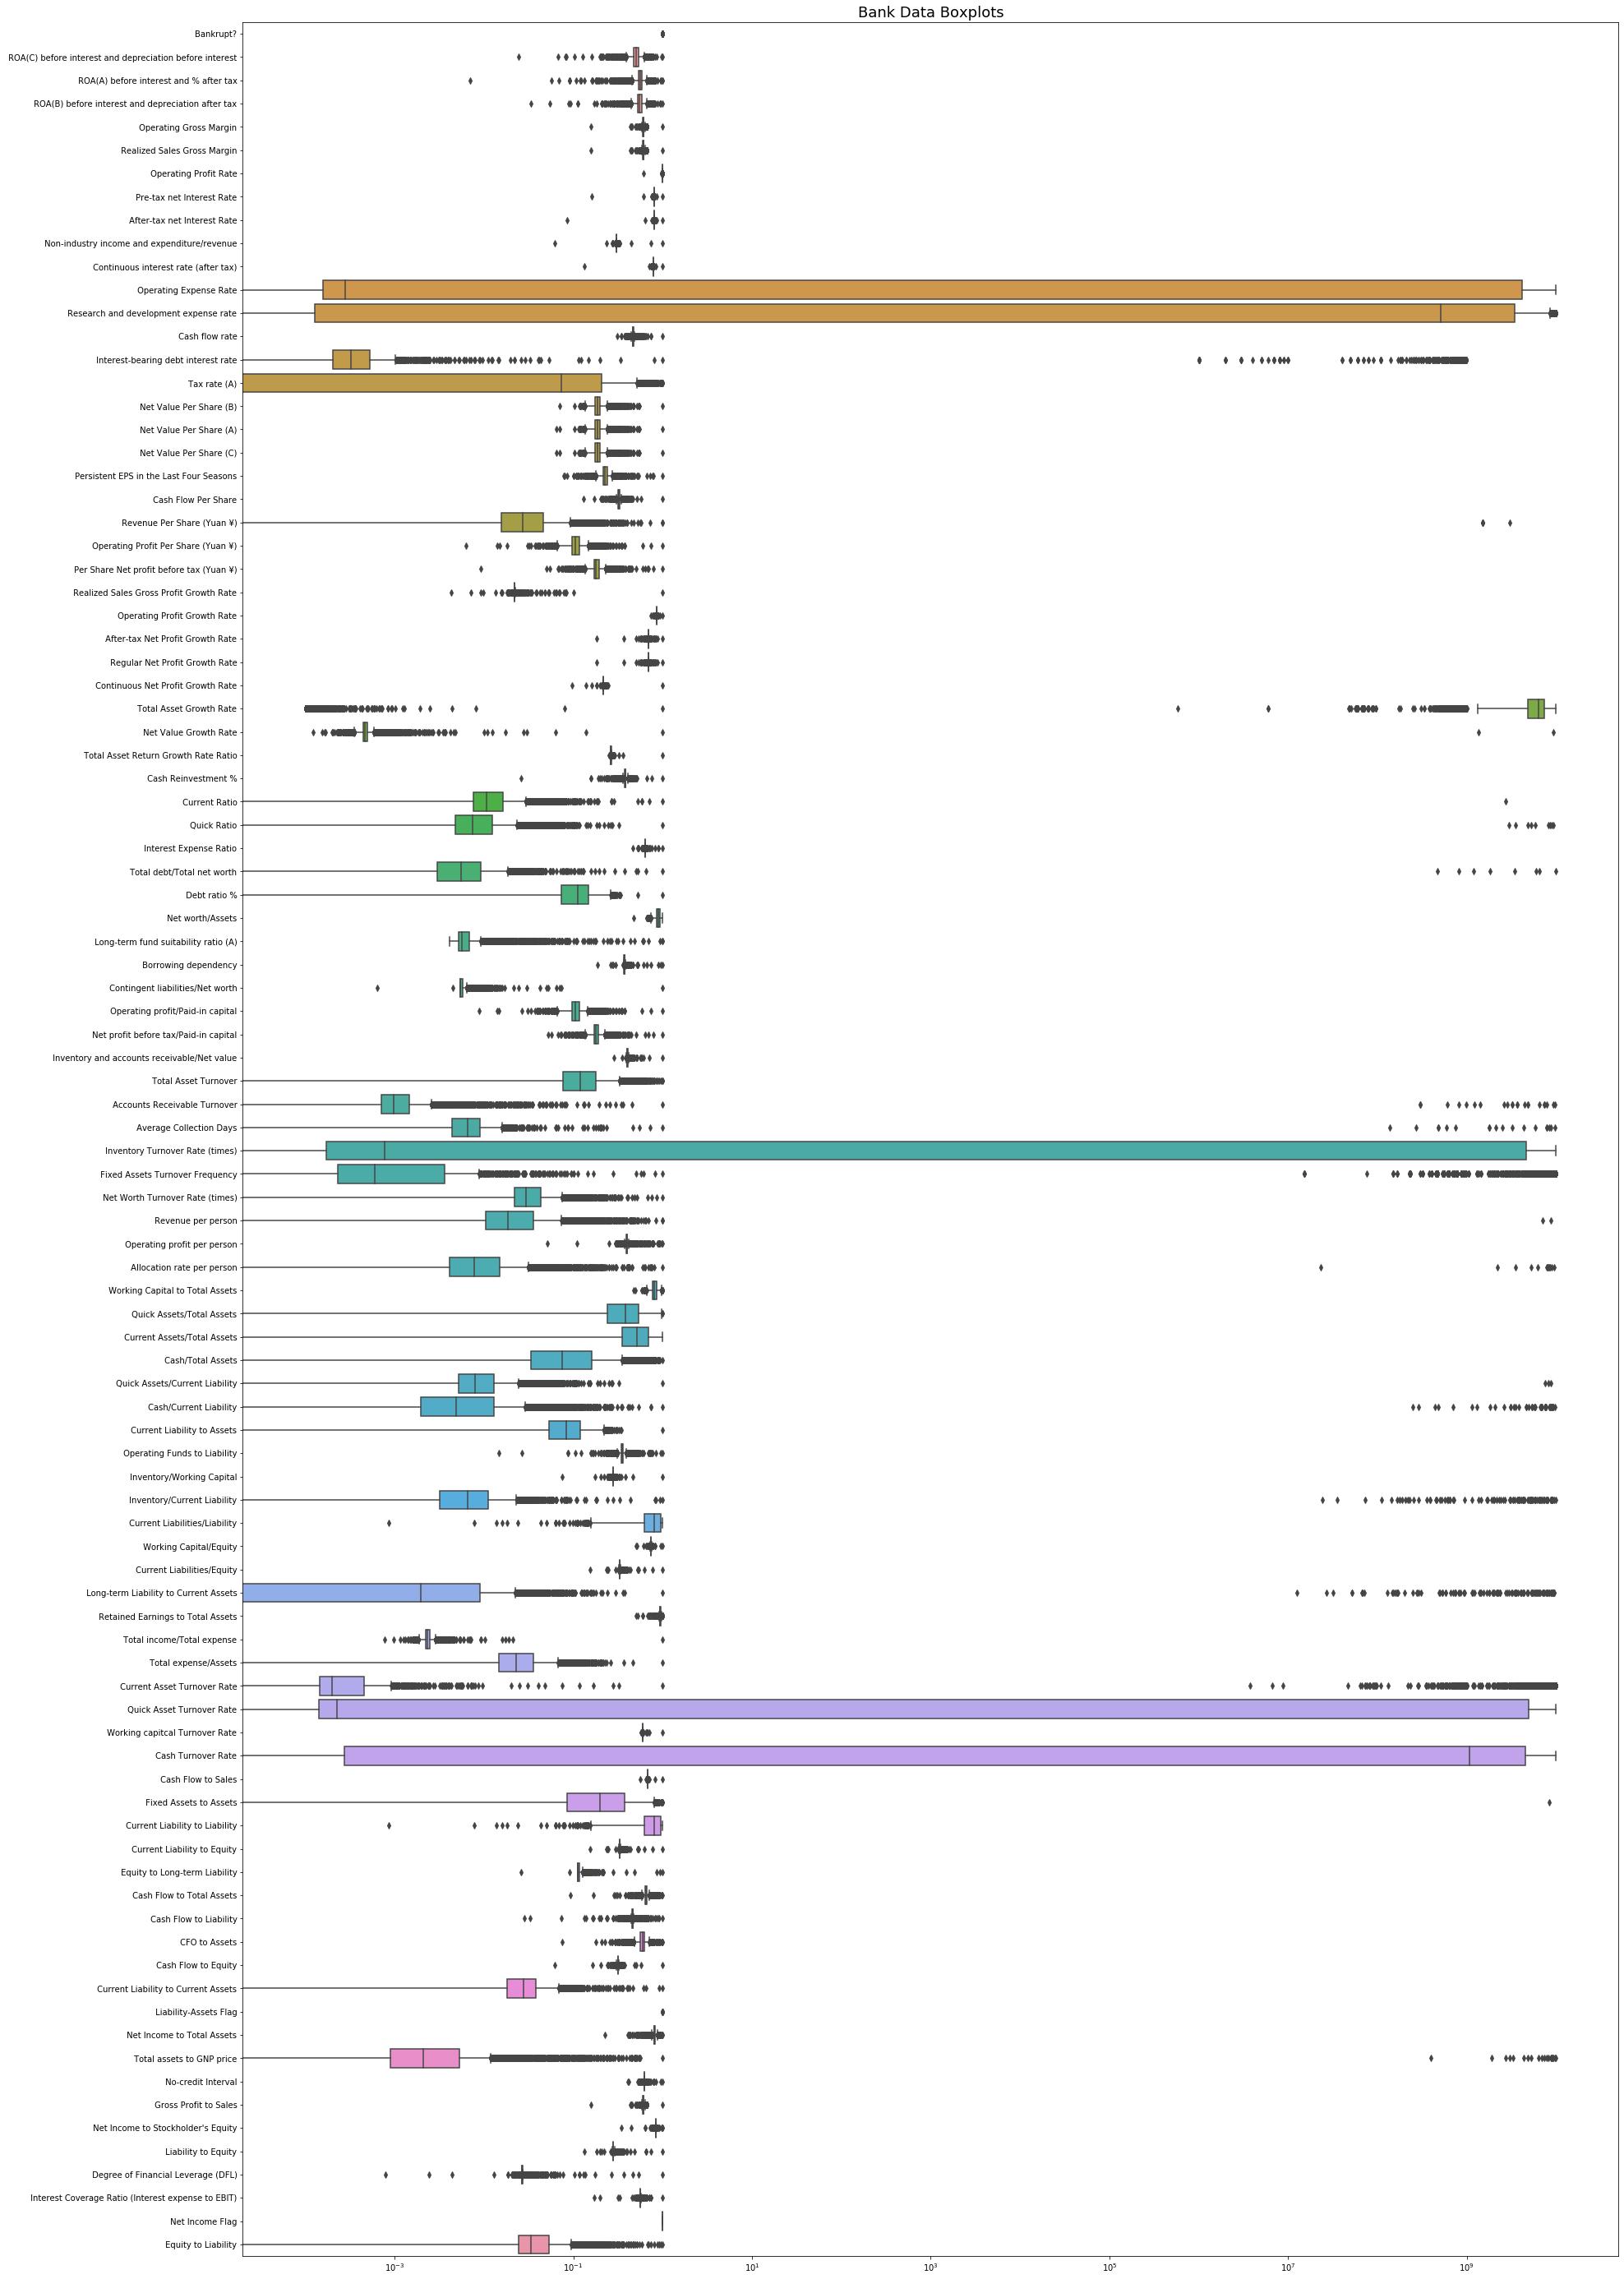

In [4]:
plt.figure(figsize = (30,50))
ax =sns.boxplot(data = data, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")

Данные содержат большое количество выбросов, поэтому уберем выбросы из датасета
Определяем внутреннюю нижнюю границу для выброса:  q25 – 1,5*(q75-q25)
Определяем внутреннюю верхнюю границу для выброса: q75 +1,5*(q75-q25)

In [5]:
def outliers_removal(feature, feature_name, data):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    diff = 1.5 * (q75 - q25)
    upper = q75 + diff
    lower = q25 - diff
    
    data = data.drop(data[(data[feature_name] > upper) | 
                                   (data[feature_name] < lower)]
                           .index)
    return data

for col in data:
    new_ds = outliers_removal(data[col], str(col), data)
    
len(new_ds)

6270

[None]

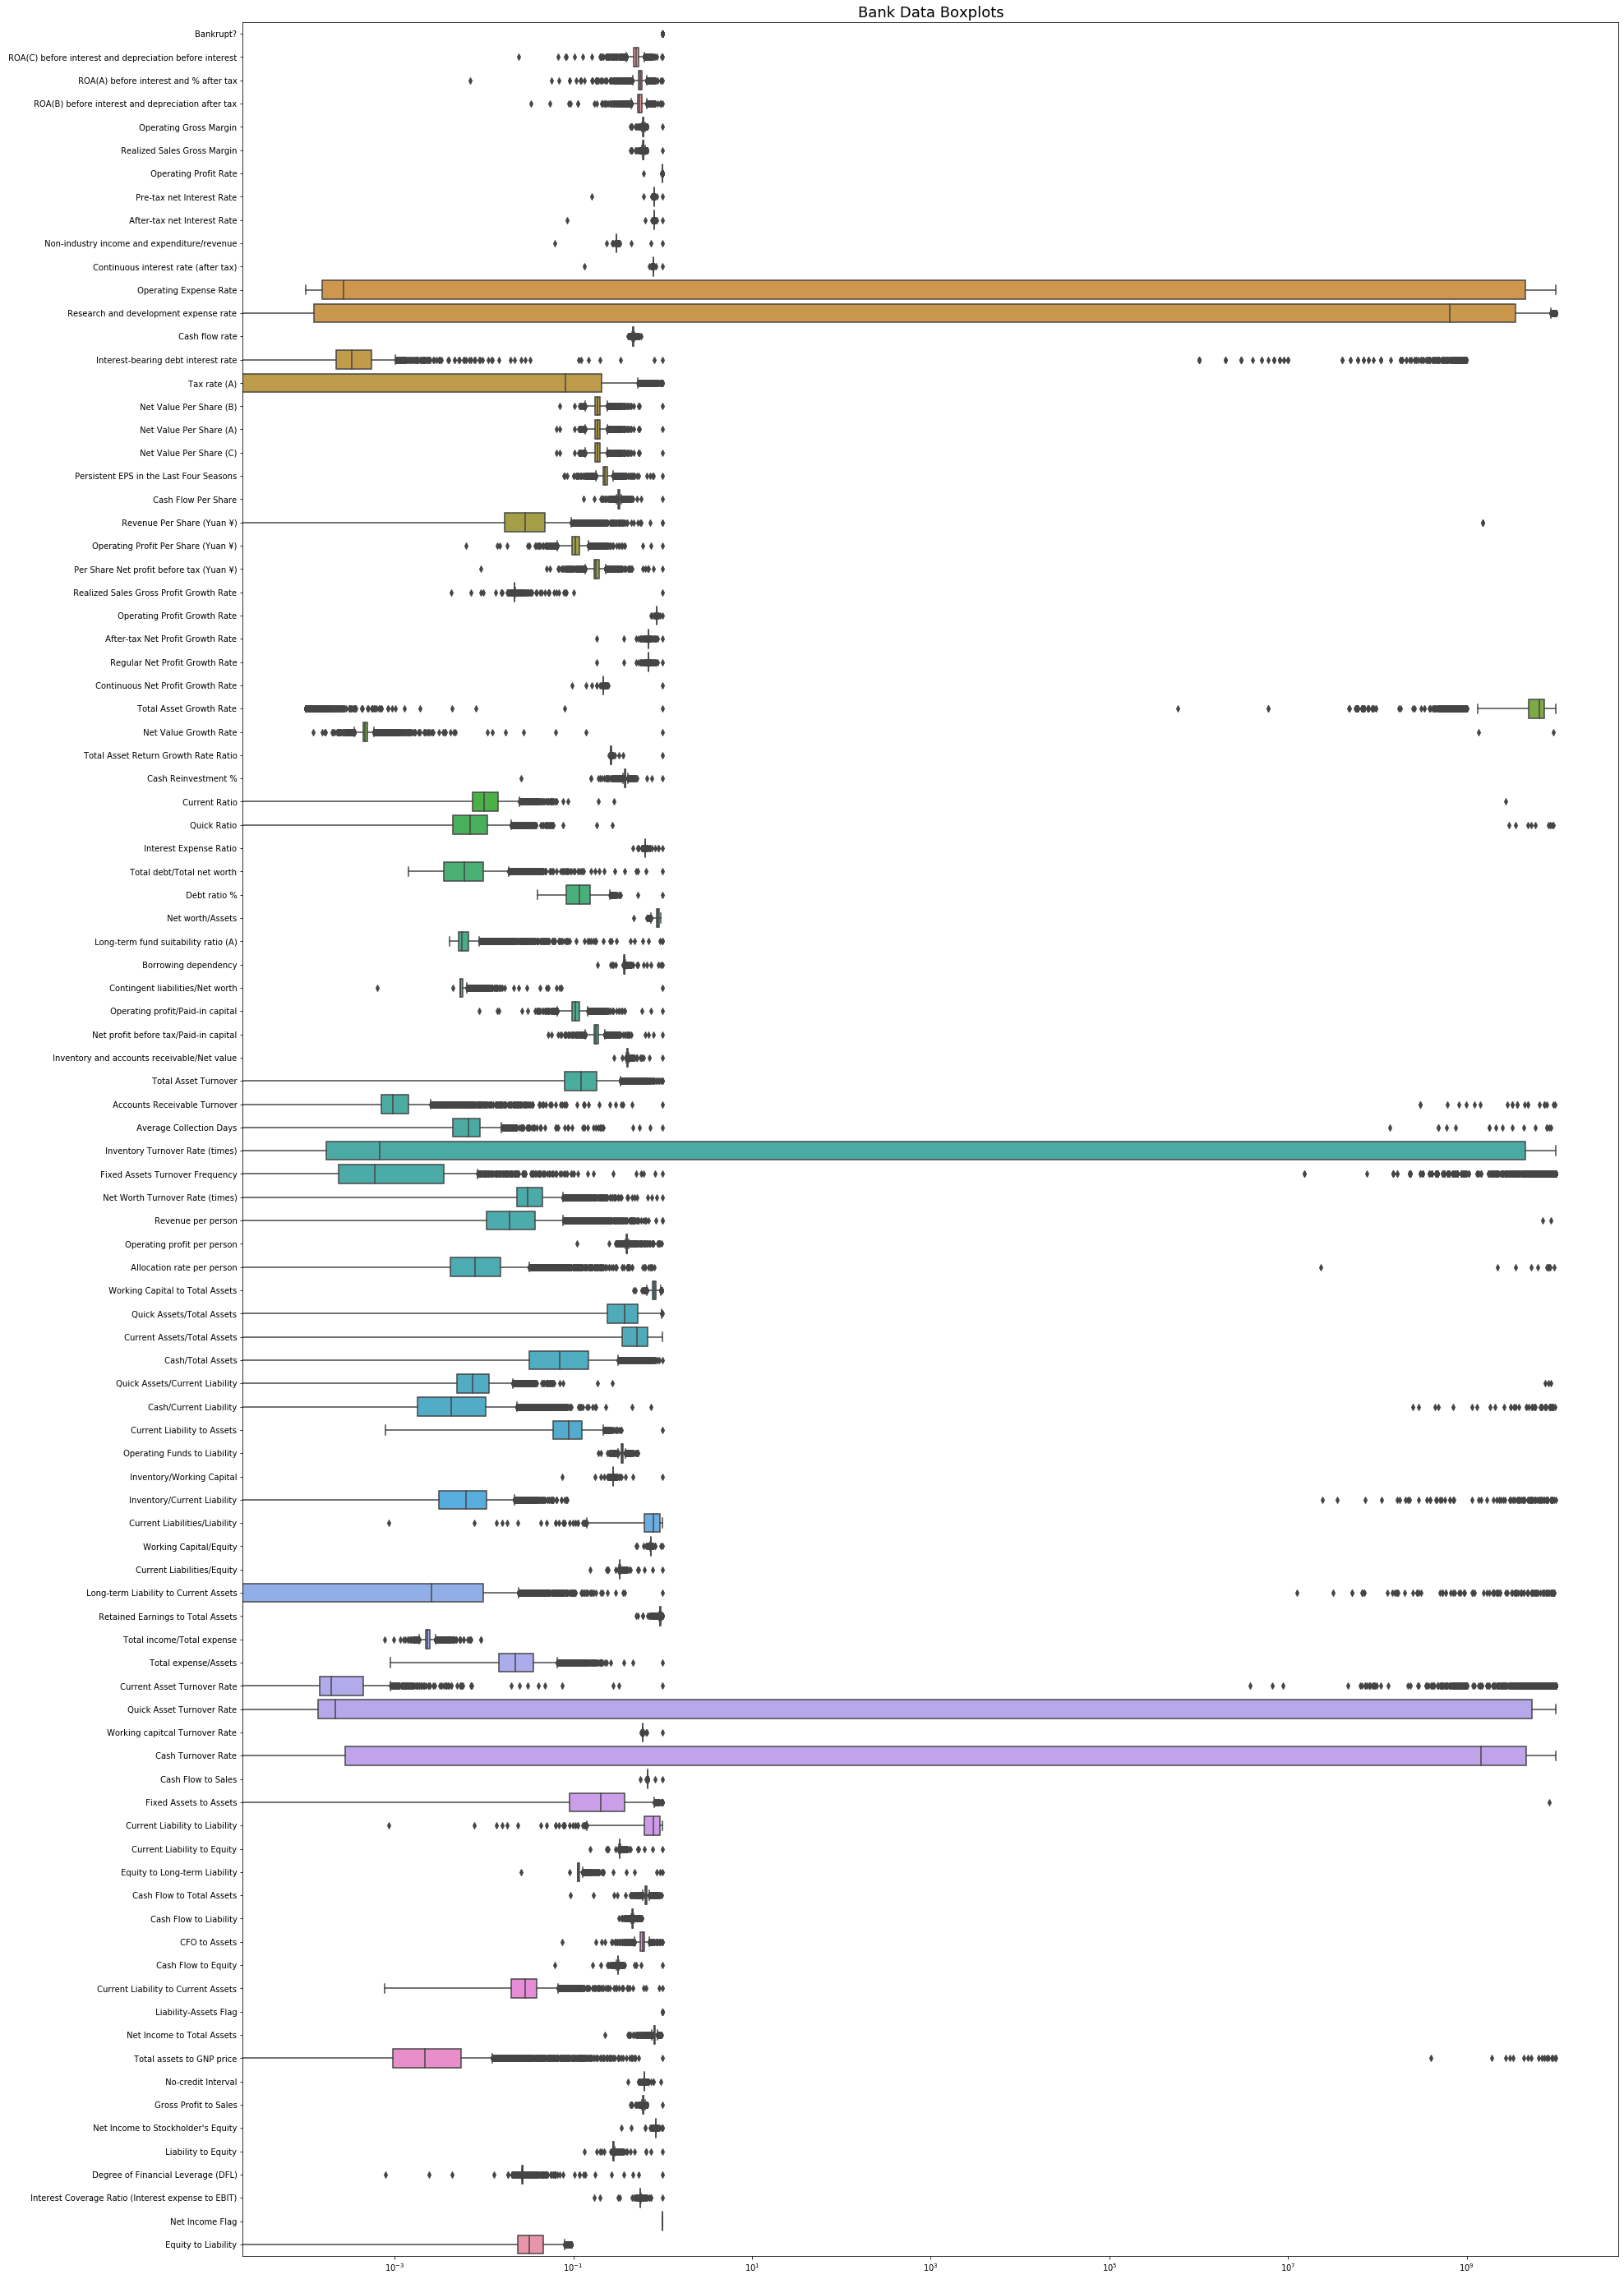

In [6]:
plt.figure(figsize = (30,50))
ax =sns.boxplot(data = new_ds, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")

Text(0.5, 1.0, 'Bankrupt vs Persistent EPS in the Last Four Seasons')

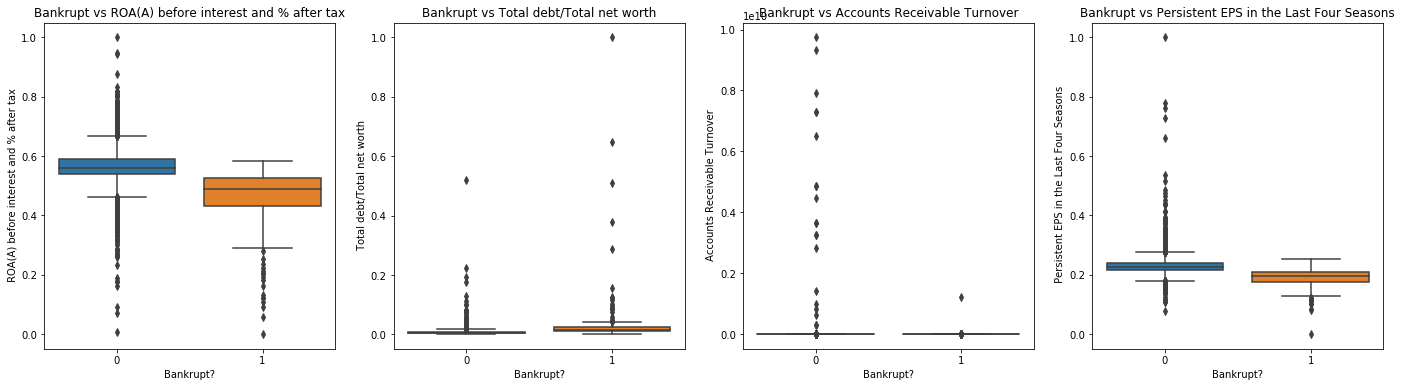

In [7]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y=" ROA(A) before interest and % after tax", data=new_ds, ax=axes[0])
axes[0].set_title('Bankrupt vs ROA(A) before interest and % after tax')

sns.boxplot(x='Bankrupt?', y=" Total debt/Total net worth", data=new_ds, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Total debt/Total net worth')


sns.boxplot(x='Bankrupt?', y=" Accounts Receivable Turnover", data=new_ds, ax=axes[2])
axes[2].set_title('Bankrupt vs Accounts Receivable Turnover')


sns.boxplot(x='Bankrupt?', y=" Persistent EPS in the Last Four Seasons", data=new_ds, ax=axes[3])  
axes[3].set_title('Bankrupt vs Persistent EPS in the Last Four Seasons') 

Text(0.5, 1.0, 'Bankrupt vs Cash Flow to Total Assets')

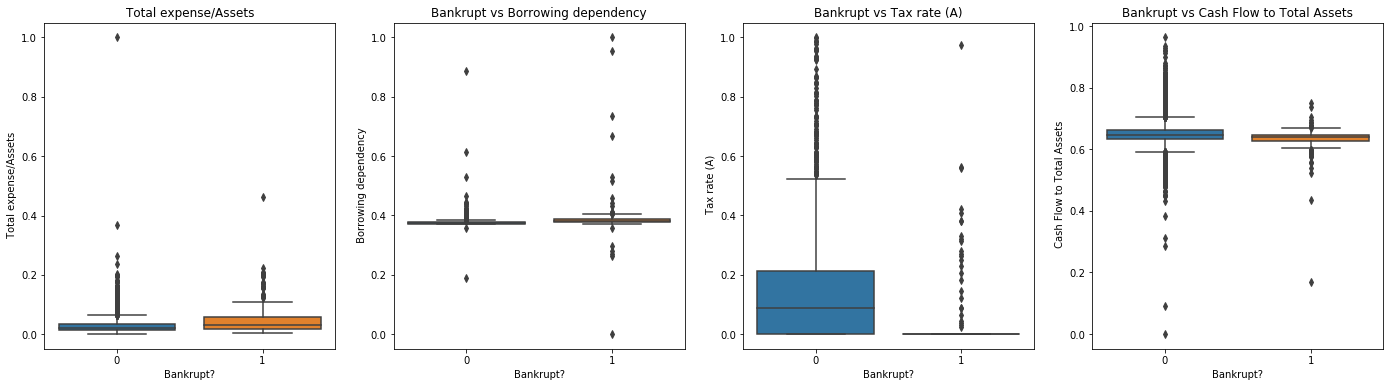

In [8]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y=" Total expense/Assets", data=new_ds, ax=axes[0])
axes[0].set_title('Total expense/Assets')

sns.boxplot(x='Bankrupt?', y=" Borrowing dependency", data=new_ds, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Borrowing dependency')


sns.boxplot(x='Bankrupt?', y=" Tax rate (A)", data=new_ds, ax=axes[2])
axes[2].set_title('Bankrupt vs Tax rate (A)')


sns.boxplot(x='Bankrupt?', y=" Cash Flow to Total Assets", data=new_ds, ax=axes[3])  
axes[3].set_title('Bankrupt vs Cash Flow to Total Assets') 

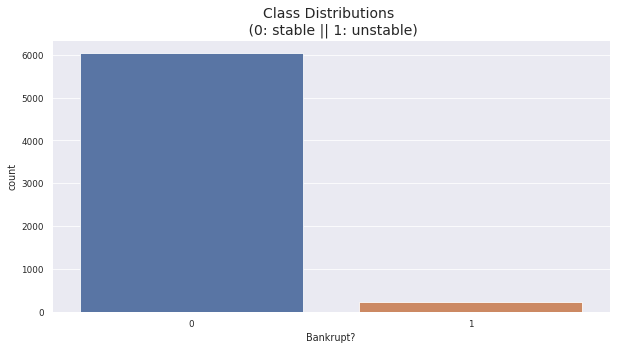

In [9]:
sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(new_ds['Bankrupt?'])
plt.title('Class Distributions \n (0: stable || 1: unstable)', fontsize=14)
plt.show()

Так как распределение класса "не банкрот" много больше, чем "банкрот", то для получения корректной модели есть два пути, либо "нарастить" класс банкротов, либо из набора стабильных компаний для обучения взять выборку количественно равную классу банкротов

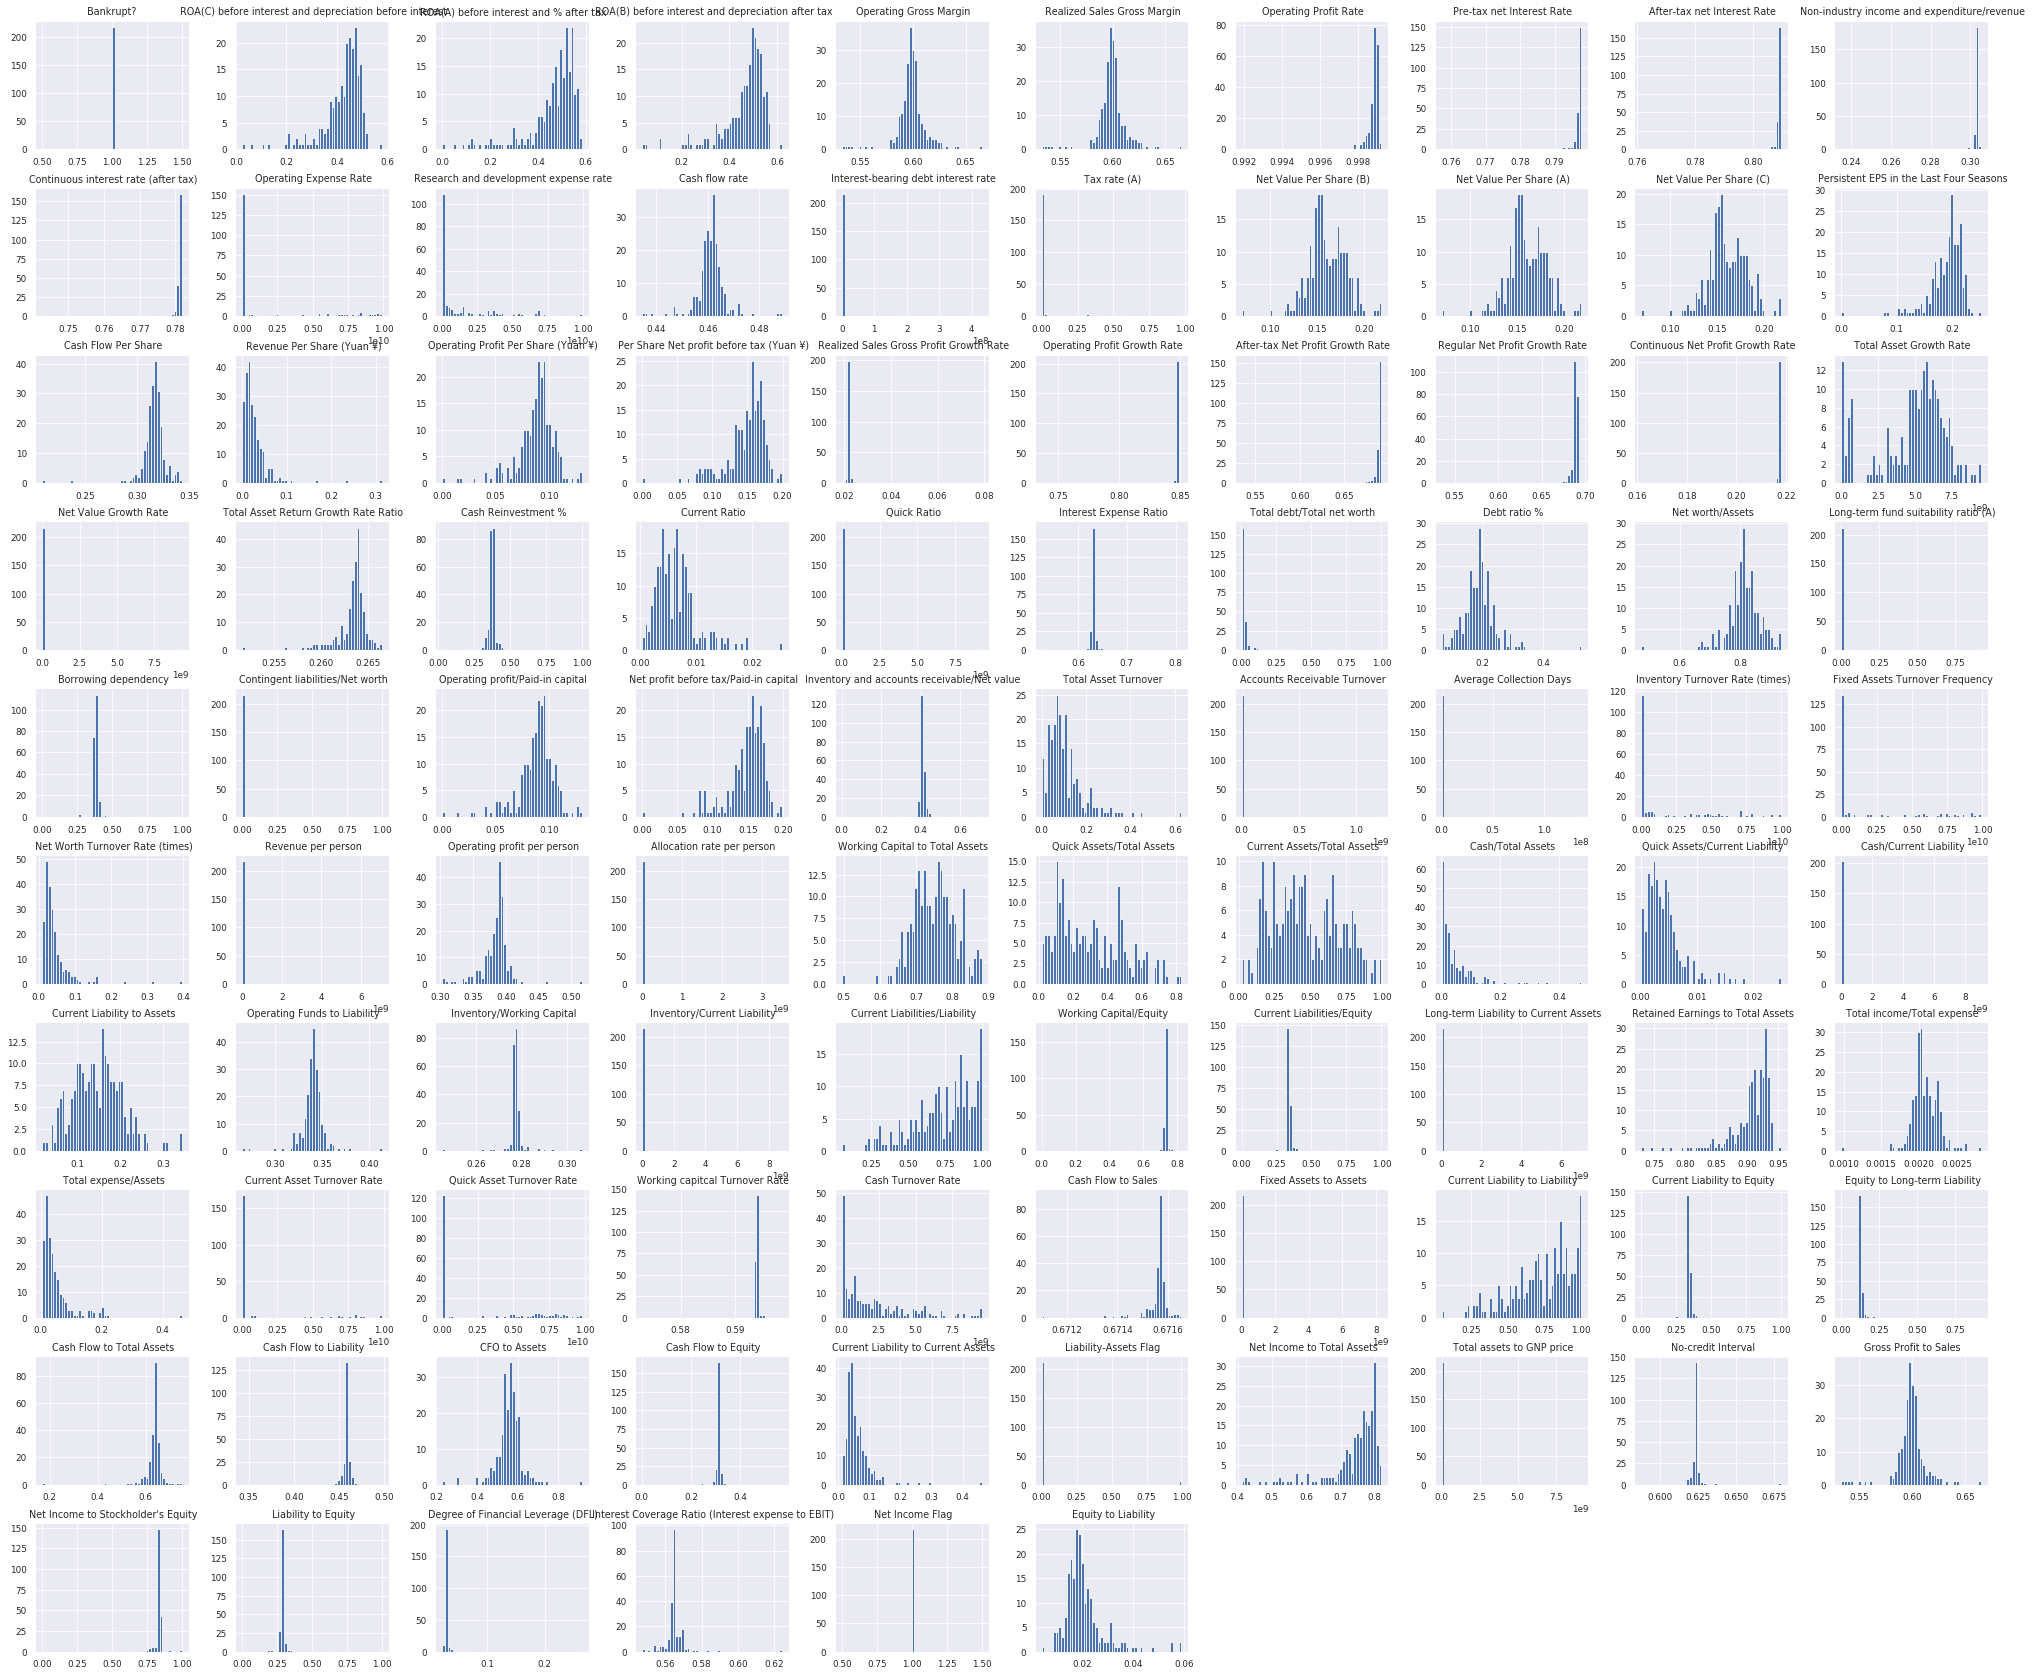

In [10]:
unstable = new_ds.loc[new_ds['Bankrupt?'] == 1]
unstable.hist(figsize = (35,30), bins = 50)
plt.show()

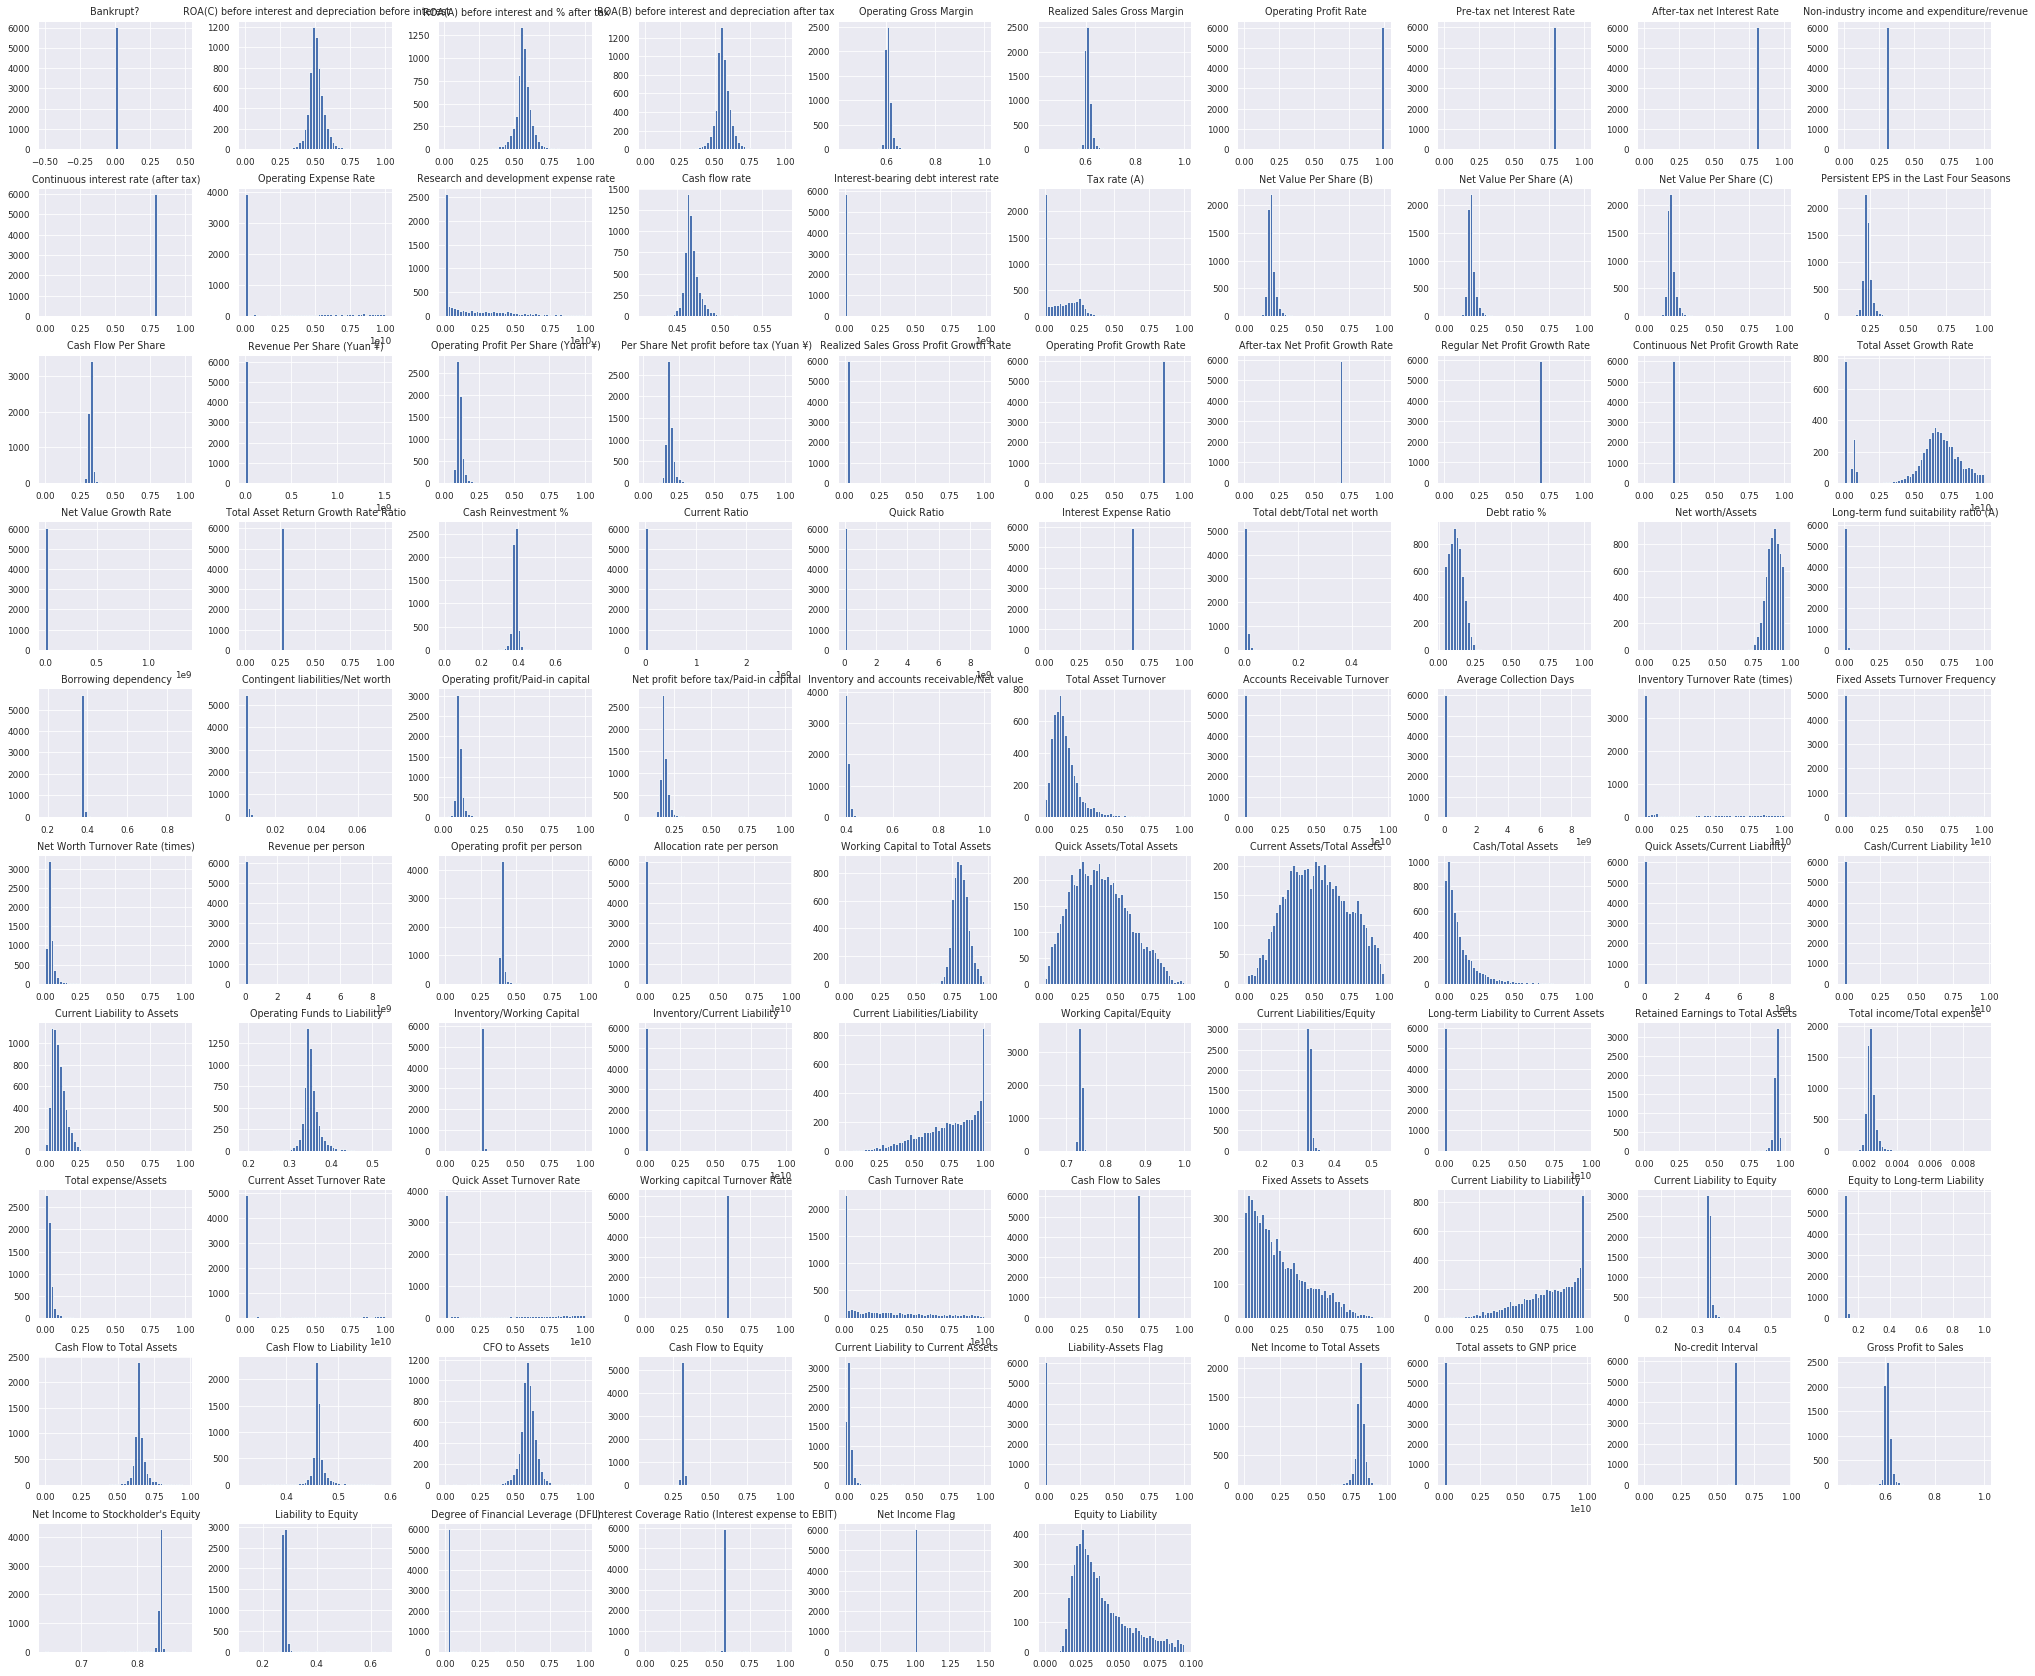

In [11]:
stable = new_ds.loc[new_ds['Bankrupt?'] == 0]
stable.hist(figsize = (35,30), bins = 50)
plt.show()

In [12]:
print(len(stable), len(unstable))

6052 218


In [13]:
# продублируем данные для обанкротившихся компаний, для того, чтобы классы были равны по количеству

data = stable
for _ in range(len(stable) // len(unstable)):
    data = data.append(unstable, ignore_index = True)
len(data)

11938

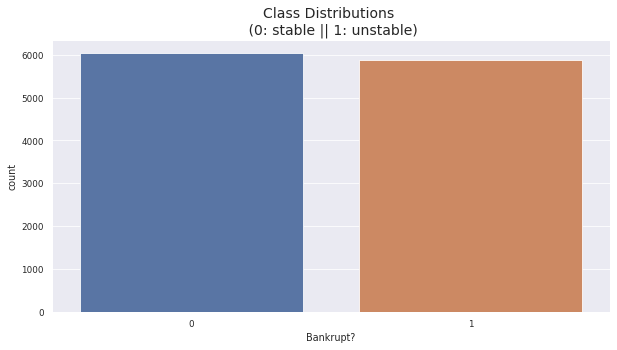

In [14]:
sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(data['Bankrupt?'])
plt.title('Class Distributions \n (0: stable || 1: unstable)', fontsize=14)
plt.show()

# The Model

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Bankrupt?'], axis=1), 
                                                    data['Bankrupt?'], 
                                                    test_size=0.33, 
                                                    random_state=42)

## XGBoost

In [16]:
gbm = xgb.XGBClassifier().fit(X_train, y_train)
xgb_predictions = gbm.predict(X_test)

[14:10:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
pd.set_option('display.max_rows', None)

feature_importances_gbm = gbm.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances_gbm})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
9,Continuous interest rate (after tax),0.331206
18,Persistent EPS in the Last Four Seasons,0.145372
34,Interest Expense Ratio,0.047296
35,Total debt/Total net worth,0.043895
5,Operating Profit Rate,0.026381
39,Borrowing dependency,0.019427
86,Total assets to GNP price,0.015953
59,Current Liability to Assets,0.014698
2,ROA(B) before interest and depreciation after...,0.012628
45,Accounts Receivable Turnover,0.010633


In [18]:
confusion_matrix = confusion_matrix(y_test.array, xgb_predictions)

total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1])/total
print('Accuracy : ', accuracy)

recall = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[1,0])
print('Recall : ', recall)

precision = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[0,1])
print('Precision : ', precision)

F = (2 * recall * accuracy)/(recall + accuracy)
print('F : ', F)

Sensitivity :  1.0
Specificity :  0.9759467758444217
Accuracy :  0.9880710659898477
Recall :  1.0
Precision :  0.9768814559763895
F :  0.993999744669986


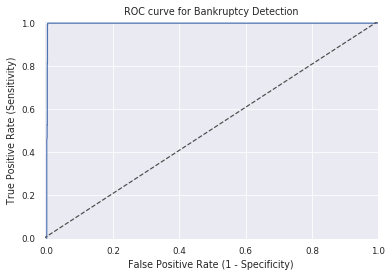

In [33]:
y_pred_quant = gbm.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Bankruptcy Detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [20]:
auc(fpr, tpr)

0.9991475215834381

### Permutation Importance

Permutation Importance работает для многих оценок scikit-learn. Идея проста: Произвольным образом переставить или перетасовать один столбец в наборе датасета валидации, оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели.

In [21]:
perm = PermutationImportance(gbm, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0109 ± 0.0030,Interest-bearing debt interest rate
0.0061 ± 0.0013,Persistent EPS in the Last Four Seasons
0.0031 ± 0.0005,Cash Turnover Rate
0.0011 ± 0.0002,Fixed Assets to Assets
0.0010 ± 0.0004,Research and development expense rate
0.0009 ± 0.0004,Current Liabilities/Liability
0.0009 ± 0.0005,Revenue per person
0.0006 ± 0.0014,Total debt/Total net worth
0.0006 ± 0.0002,Average Collection Days
0.0004 ± 0.0002,Total Asset Return Growth Rate Ratio


## Catboost

In [22]:
cat = CatBoostClassifier().fit(X_train, y_train)
cat_predictions = cat.predict(X_test)

Learning rate set to 0.025033
0:	learn: 0.6599747	total: 77ms	remaining: 1m 16s
1:	learn: 0.6351353	total: 89.8ms	remaining: 44.8s
2:	learn: 0.6111544	total: 98.3ms	remaining: 32.7s
3:	learn: 0.5872545	total: 105ms	remaining: 26.2s
4:	learn: 0.5663985	total: 111ms	remaining: 22.1s
5:	learn: 0.5448773	total: 117ms	remaining: 19.4s
6:	learn: 0.5258355	total: 123ms	remaining: 17.5s
7:	learn: 0.5049554	total: 129ms	remaining: 16s
8:	learn: 0.4906095	total: 135ms	remaining: 14.9s
9:	learn: 0.4750760	total: 142ms	remaining: 14.1s
10:	learn: 0.4593330	total: 148ms	remaining: 13.3s
11:	learn: 0.4443852	total: 154ms	remaining: 12.7s
12:	learn: 0.4291302	total: 160ms	remaining: 12.2s
13:	learn: 0.4177562	total: 167ms	remaining: 11.8s
14:	learn: 0.4056772	total: 173ms	remaining: 11.4s
15:	learn: 0.3928502	total: 179ms	remaining: 11s
16:	learn: 0.3830547	total: 185ms	remaining: 10.7s
17:	learn: 0.3743327	total: 191ms	remaining: 10.4s
18:	learn: 0.3632356	total: 198ms	remaining: 10.2s
19:	learn: 0.

180:	learn: 0.0927673	total: 1.41s	remaining: 6.38s
181:	learn: 0.0921352	total: 1.42s	remaining: 6.37s
182:	learn: 0.0917356	total: 1.43s	remaining: 6.38s
183:	learn: 0.0912287	total: 1.44s	remaining: 6.37s
184:	learn: 0.0907745	total: 1.44s	remaining: 6.36s
185:	learn: 0.0903463	total: 1.45s	remaining: 6.36s
186:	learn: 0.0900906	total: 1.46s	remaining: 6.36s
187:	learn: 0.0898559	total: 1.47s	remaining: 6.36s
188:	learn: 0.0893643	total: 1.48s	remaining: 6.34s
189:	learn: 0.0889181	total: 1.49s	remaining: 6.33s
190:	learn: 0.0885347	total: 1.49s	remaining: 6.32s
191:	learn: 0.0881733	total: 1.5s	remaining: 6.31s
192:	learn: 0.0876402	total: 1.5s	remaining: 6.3s
193:	learn: 0.0873763	total: 1.51s	remaining: 6.28s
194:	learn: 0.0870587	total: 1.52s	remaining: 6.27s
195:	learn: 0.0867801	total: 1.52s	remaining: 6.26s
196:	learn: 0.0864603	total: 1.53s	remaining: 6.25s
197:	learn: 0.0859382	total: 1.54s	remaining: 6.23s
198:	learn: 0.0857039	total: 1.54s	remaining: 6.22s
199:	learn: 0.0

362:	learn: 0.0447189	total: 2.6s	remaining: 4.57s
363:	learn: 0.0446049	total: 2.61s	remaining: 4.56s
364:	learn: 0.0445328	total: 2.62s	remaining: 4.55s
365:	learn: 0.0443870	total: 2.62s	remaining: 4.54s
366:	learn: 0.0442328	total: 2.63s	remaining: 4.53s
367:	learn: 0.0440715	total: 2.63s	remaining: 4.53s
368:	learn: 0.0439922	total: 2.64s	remaining: 4.52s
369:	learn: 0.0438606	total: 2.65s	remaining: 4.51s
370:	learn: 0.0437234	total: 2.65s	remaining: 4.5s
371:	learn: 0.0435685	total: 2.66s	remaining: 4.49s
372:	learn: 0.0434290	total: 2.67s	remaining: 4.48s
373:	learn: 0.0432911	total: 2.67s	remaining: 4.47s
374:	learn: 0.0431112	total: 2.68s	remaining: 4.46s
375:	learn: 0.0428825	total: 2.68s	remaining: 4.46s
376:	learn: 0.0426221	total: 2.69s	remaining: 4.45s
377:	learn: 0.0425177	total: 2.7s	remaining: 4.44s
378:	learn: 0.0423780	total: 2.7s	remaining: 4.43s
379:	learn: 0.0421260	total: 2.71s	remaining: 4.42s
380:	learn: 0.0419315	total: 2.72s	remaining: 4.41s
381:	learn: 0.04

551:	learn: 0.0237549	total: 3.81s	remaining: 3.09s
552:	learn: 0.0237039	total: 3.81s	remaining: 3.08s
553:	learn: 0.0236317	total: 3.82s	remaining: 3.08s
554:	learn: 0.0235459	total: 3.83s	remaining: 3.07s
555:	learn: 0.0234486	total: 3.84s	remaining: 3.06s
556:	learn: 0.0233442	total: 3.84s	remaining: 3.06s
557:	learn: 0.0232888	total: 3.85s	remaining: 3.05s
558:	learn: 0.0232341	total: 3.85s	remaining: 3.04s
559:	learn: 0.0232029	total: 3.86s	remaining: 3.04s
560:	learn: 0.0231066	total: 3.87s	remaining: 3.03s
561:	learn: 0.0230035	total: 3.88s	remaining: 3.02s
562:	learn: 0.0229153	total: 3.89s	remaining: 3.02s
563:	learn: 0.0228312	total: 3.89s	remaining: 3.01s
564:	learn: 0.0227823	total: 3.9s	remaining: 3s
565:	learn: 0.0226848	total: 3.91s	remaining: 3s
566:	learn: 0.0225803	total: 3.91s	remaining: 2.99s
567:	learn: 0.0224842	total: 3.92s	remaining: 2.98s
568:	learn: 0.0224223	total: 3.93s	remaining: 2.97s
569:	learn: 0.0223670	total: 3.93s	remaining: 2.97s
570:	learn: 0.02226

738:	learn: 0.0137441	total: 5.02s	remaining: 1.77s
739:	learn: 0.0136825	total: 5.02s	remaining: 1.76s
740:	learn: 0.0136596	total: 5.03s	remaining: 1.76s
741:	learn: 0.0136005	total: 5.04s	remaining: 1.75s
742:	learn: 0.0135892	total: 5.05s	remaining: 1.75s
743:	learn: 0.0135209	total: 5.05s	remaining: 1.74s
744:	learn: 0.0134760	total: 5.06s	remaining: 1.73s
745:	learn: 0.0134262	total: 5.07s	remaining: 1.72s
746:	learn: 0.0133876	total: 5.07s	remaining: 1.72s
747:	learn: 0.0133559	total: 5.08s	remaining: 1.71s
748:	learn: 0.0133208	total: 5.08s	remaining: 1.7s
749:	learn: 0.0132708	total: 5.09s	remaining: 1.7s
750:	learn: 0.0132448	total: 5.1s	remaining: 1.69s
751:	learn: 0.0131924	total: 5.1s	remaining: 1.68s
752:	learn: 0.0131553	total: 5.11s	remaining: 1.68s
753:	learn: 0.0131282	total: 5.11s	remaining: 1.67s
754:	learn: 0.0130925	total: 5.12s	remaining: 1.66s
755:	learn: 0.0130490	total: 5.13s	remaining: 1.65s
756:	learn: 0.0130136	total: 5.13s	remaining: 1.65s
757:	learn: 0.01

926:	learn: 0.0088986	total: 6.44s	remaining: 507ms
927:	learn: 0.0088836	total: 6.45s	remaining: 501ms
928:	learn: 0.0088729	total: 6.46s	remaining: 494ms
929:	learn: 0.0088639	total: 6.46s	remaining: 487ms
930:	learn: 0.0088522	total: 6.47s	remaining: 480ms
931:	learn: 0.0088272	total: 6.48s	remaining: 473ms
932:	learn: 0.0088034	total: 6.49s	remaining: 466ms
933:	learn: 0.0087880	total: 6.49s	remaining: 459ms
934:	learn: 0.0087584	total: 6.5s	remaining: 452ms
935:	learn: 0.0087445	total: 6.51s	remaining: 445ms
936:	learn: 0.0087383	total: 6.51s	remaining: 438ms
937:	learn: 0.0087204	total: 6.52s	remaining: 431ms
938:	learn: 0.0087040	total: 6.53s	remaining: 424ms
939:	learn: 0.0086990	total: 6.53s	remaining: 417ms
940:	learn: 0.0086770	total: 6.54s	remaining: 410ms
941:	learn: 0.0086690	total: 6.54s	remaining: 403ms
942:	learn: 0.0086430	total: 6.55s	remaining: 396ms
943:	learn: 0.0086178	total: 6.56s	remaining: 389ms
944:	learn: 0.0086039	total: 6.56s	remaining: 382ms
945:	learn: 0

In [23]:
pd.set_option('display.max_rows', None)

feature_importances_cat = cat.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train), 'feature_importances': feature_importances_cat})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
13,Interest-bearing debt interest rate,5.589614
39,Borrowing dependency,3.767596
33,Quick Ratio,3.670890
52,Allocation rate per person,3.193091
8,Non-industry income and expenditure/revenue,3.066787
45,Accounts Receivable Turnover,2.895168
18,Persistent EPS in the Last Four Seasons,2.690153
73,Cash Turnover Rate,2.527184
46,Average Collection Days,2.510398
28,Total Asset Growth Rate,2.208926


In [26]:
confusion_matrix = confusion_matrix(y_test.array, cat_predictions)

total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1])/total
print('Accuracy : ', accuracy)

recall = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[1,0])
print('Recall : ', recall)

precision = confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[0,1])
print('Precision : ', precision)

F = (2 * recall * accuracy)/(recall + accuracy)
print('F : ', F)

Sensitivity :  1.0
Specificity :  0.9734558448187851
Accuracy :  0.9868020304568528
Recall :  1.0
Precision :  0.9744220363994097
F :  0.9933571793561574


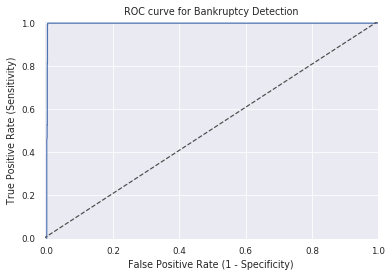

In [32]:
y_pred_quant = gbm.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Bankruptcy Detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [28]:
auc(fpr, tpr)

0.9991475215834381

In [29]:
perm = PermutationImportance(cat, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0019 ± 0.0009,Cash Turnover Rate
0.0010 ± 0.0006,Revenue per person
0.0009 ± 0.0012,Interest-bearing debt interest rate
0.0009 ± 0.0005,Inventory/Working Capital
0.0005 ± 0.0010,Research and development expense rate
0.0005 ± 0.0006,Liability to Equity
0.0005 ± 0.0006,Cash Reinvestment %
0.0004 ± 0.0004,Inventory and accounts receivable/Net value
0.0003 ± 0.0006,Cash Flow to Sales
0.0003 ± 0.0004,Cash Flow to Liability
